# CMPE 260 - Assignment 1

## 1. Finish the `__init__()` in `MyVAE.py` model.

At this point this is not really a VAE yet, but you should be able 
to train the model. Run `train_vae.py` to train. 
Then, run `sample_vae.py` to generate a few images with your model.   
*Note: you can run `MyVAE.py` to quickly test if your model is working.      
Save two generated images.   

#### Q. What model components are used in the forward pass and in sampling?    
At this point, our model is just a simple autoencoder and not a variational one. In the forward pass, an input image is passed through the encoder, the output of which is passed to z_simple that represents the latent space, and its output is passed to the decoder network. During sampling, if the user has not provided a latent space vector, a random vector of dimensions same as the latent space is sampled from normal distribution, and passed to the decoder network. The decoder network is then responsible for generating the image corresponding to the latent space vector.

### 1.1 MyVAE.py

In [ ]:
import copy

import torch
from torch import nn
from torch.nn import functional as F


class MyVAE(nn.Module):
    def __init__(self,
                 in_channels: int,
                 latent_dim: int,
                 hidden_dims=None):
        super().__init__()

        self.latent_dim = latent_dim

        # Encoder

        modules = []
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256, 512]

        self.hidden_dims = copy.copy(hidden_dims)

        ##############################
        # replace ??? with proper local variables

        in_dim = in_channels
        for h_dim in self.hidden_dims:
            # one convolution layer
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels=in_dim,
                              out_channels=h_dim,
                              kernel_size=3,
                              stride=2,
                              padding=1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_dim = h_dim

        self.encoder = nn.Sequential(*modules)

        ##############################

        ##############################
        # the central hidden layer of the model.

        # autoencoder version of the representation layer. This is used by default
        self.z_simple = nn.Linear(self.hidden_dims[-1] * 4, latent_dim)

        # VAE Reparametrization Layer
        self.z_mu = nn.Linear(hidden_dims[-1] * 4, latent_dim)
        self.z_var = nn.Linear(hidden_dims[-1] * 4, latent_dim)

        ##############################

        # Decoder
        modules = []

        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] * 4)

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride=2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )

        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
            nn.ConvTranspose2d(hidden_dims[-1],
                               hidden_dims[-1],
                               kernel_size=3,
                               stride=2,
                               padding=1,
                               output_padding=1),
            nn.BatchNorm2d(hidden_dims[-1]),
            nn.LeakyReLU(),
            nn.Conv2d(hidden_dims[-1],
                      out_channels=3,
                      kernel_size=3,
                      padding=1),
            nn.Tanh())

    def encode(self, x):
        """Encodes the input into parameters of a normal distribution."""
        z = self.encoder(x)
        z = torch.flatten(z, start_dim=1)

        ##############################
        # update this along with reparameterize() and forward() to turn this into vae
        # Compute mean and variance of the latent distribution
        # Use mu and var layers we defined in the init

        # mu = ???
        # log_var = ???
        # z = [mu, log_var]
        z = self.z_simple(z)

        ##############################

        return z

    def decode(self, z):
        """Latent space to image space"""
        y = self.decoder_input(z)
        y = y.view(-1, self.hidden_dims[-1], 2, 2)  #
        y = self.decoder(y)
        y = self.final_layer(y)
        return y

    def reparameterize(self, mu, logvar):
        """Reparameterization trick: sample from N(mu, var) using N(0,1)"""

        std = torch.exp(0.5 * logvar)

        ##############################
        # update this along with forward() and encode() to turn this into vae

        # hint: torch.randn_like samples from normal distribution,
        # and returns a tensor of the same size as its input
        # eps = ???

        ##############################

        return eps * std + mu

    def forward(self, x):

        ##############################
        # update this along with reparametrize() and encode() to turn this into vae

        z = self.encode(x)
        mu = torch.zeros_like(z)
        log_var = torch.zeros_like(z)

        # mu, log_var = self.encode(x)
        # z = self.reparameterize(mu, log_var)

        ##############################

        return [self.decode(z), x, mu, log_var]

    def loss(self, x, y, z_mu, z_log_var, kl_w):
        """VAE loss
        :param kl_w: Account for the minibatch samples from the dataset"""

        recons_loss = F.mse_loss(y, x)

        kl_loss = torch.mean(-0.5 * torch.sum(1 + z_log_var - z_mu ** 2 - z_log_var.exp(), dim=1), dim=0)

        loss = recons_loss + kl_w * kl_loss
        return loss

    def sample(self, z=None, device='cpu'):
        """Sample image from the latent space."""
        if not z:
            z = torch.randn(1, self.latent_dim).to(device)
        else:
            assert z.shape[1] == self.latent_dim, "z must be of shape [1, {}]".format(self.latent_dim)

        y = torch.clamp(self.decode(z), 0.0, 1.0)
        return y

    def generate(self, x):
        """return the reconstructed image from x"""
        return self.forward(x)[0]


if __name__ == "__main__":
    vae = MyVAE(3, 10)
    x = torch.randn(5, 3, 64, 64)
    y, _, mu, logvar = vae(x)
    loss = vae.loss(y, x, mu, logvar, 1)
    print(loss)

### 1.2 train_vae.py

In [ ]:
import random
import torch
import gym
import numpy as np
import cv2
import matplotlib.pyplot as plt

from torch import optim

from MyVAE import MyVAE

# we will crop the image to remove the top and bottom (those are always white)
crop_proportions = (0.4, 0.0, 1.0, 1.0)

# after the crop, we will reduce the image size to these dimensions for faster training
img_dim = (64, 64)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def train_vae():

    # initialize the gym environment
    #########################

    # try different environments
    env = gym.make("CartPole-v1")

    #########################
    # first observation from the environment
    obs = env.reset()
    img = env.render(mode='rgb_array')
    crop_dim = (
        int(crop_proportions[0] * img.shape[0]),
        int(crop_proportions[1] * img.shape[1]),
        int(crop_proportions[2] * img.shape[0]),
        int(crop_proportions[3] * img.shape[1])
    )

    # VAE

    input_channels = 3
    latent_dim = 10
    training_size = 2000
    batch_size = latent_dim * 10
    n_epochs = 400

    # initialize the VAE
    # VAE model
    vae = MyVAE(
        in_channels=input_channels,
        latent_dim=latent_dim,
    ).to(device)
    optimizer = optim.Adam(vae.parameters(), lr=0.001)

    imgs = np.zeros((training_size, input_channels, *img_dim), dtype=np.float32)

    # Collect pixel data from the gym

    # episode frame counter
    frame_idx = 0

    for i in range(training_size):
        frame_idx += 1

        # get a random action in this environment
        action = env.action_space.sample()

        # obs is observation data from the env. 
        # Look at the gym code to find which one is a pole angle. 
        # https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py
        obs, reward, done, info = env.step(action)

        # get pixel observations, crop, and resize
        img = env.render(mode='rgb_array')
        img = img[crop_dim[0]: crop_dim[2], crop_dim[1]: crop_dim[3], :]
        img = cv2.resize(img, dsize=img_dim, interpolation=cv2.INTER_CUBIC)
        # how the model will see the image after crop and resize
        # cv2.imshow('img', img)
        # cv2.waitKey(1)
        img = img.swapaxes(0, 2).reshape((1, input_channels, *img_dim)).astype(np.float32) / 255.0

        #################

        # add some conditional logic to save the images you need
        # collect data
        # if obs???:
        imgs[i] = img

        #################

        #################

        # update the reset conditions to save the images you need
        # if ???:
        if done:
            obs = env.reset()
            frame_idx = 0

        #################

    env.close()

    # visualization init
    plt.ion()
    plt.show()

    # train VAE
    for i in range(n_epochs):
        # observations for cvae to use as labels
        start_idx = random.randint(0, training_size - batch_size)

        train_imgs = imgs[start_idx : start_idx + batch_size]

        out_imgs = vae(
            torch.from_numpy(train_imgs.copy()).to(device),
        )
        loss = vae.loss(*out_imgs, kl_w=0.0005)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(loss)

        # get a few generated images
        rand_idx = np.random.randint(0, batch_size - 1)
        im = out_imgs[0][rand_idx: rand_idx + 1].detach().cpu().numpy().reshape(
            (1, 3, *img_dim)).swapaxes(1, 3)
        im = (im * 255.0).astype(np.uint8)

        # show generated image
        plt.subplot(
            np.ceil(np.sqrt(1 * n_epochs)).astype(int),
            np.ceil(np.sqrt(1 * n_epochs)).astype(int),
            i + 1
        )
        plt.imshow(im[0], aspect='auto')
        plt.axis('off')
        plt.show()
        plt.pause(0.1)

    # save our model
    torch.save(vae.state_dict(), 'vae.pth')
    plt.savefig('vae_training.png')
    plt.show()


if __name__ == '__main__':
    train_vae()

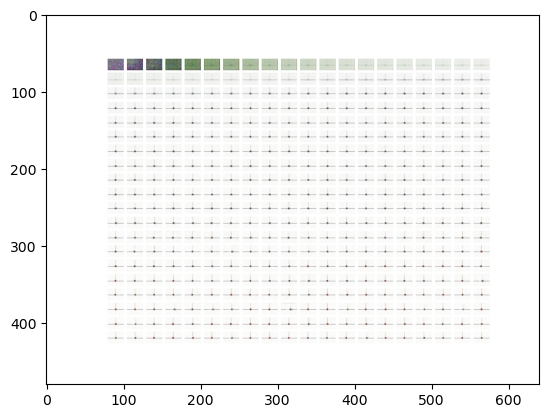

In [27]:
plt.figure()
img = plt.imread('vae_training 1.png')
plt.imshow(img)
plt.show()

### 1.3 sample_vae.py

In [ ]:
from argparse import ArgumentParser

import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Button


img_dim = (64, 64)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def my_vae_generate(filepath):
    vae = MyVAE(in_channels=3, latent_dim=10).to(device)
    vae.load_state_dict(torch.load(filepath))

    def generate(_):
        out_img = vae.sample(device=device)
        im = out_img[0].detach().cpu().numpy()
        im = im.reshape((3, *img_dim)).swapaxes(0, 2)
        im = (im * 255.0).astype(np.uint8)
        plt.subplot(2, 1, 1)
        plt.imshow(im)
        plt.show()

    plt.subplot(2, 1, 2)
    plt.axis('off')
    b = Button(plt.axes([0.35, 0.1, 0.30, 0.10]), 'Generate')
    b.on_clicked(generate)
    generate(None)
    plt.show()


if __name__ == "__main__":
    parser = ArgumentParser()
    parser.add_argument("-f", "--file", type=str, default="vae.pth", help="file name")
    args = parser.parse_args()

    my_vae_generate(args.file)


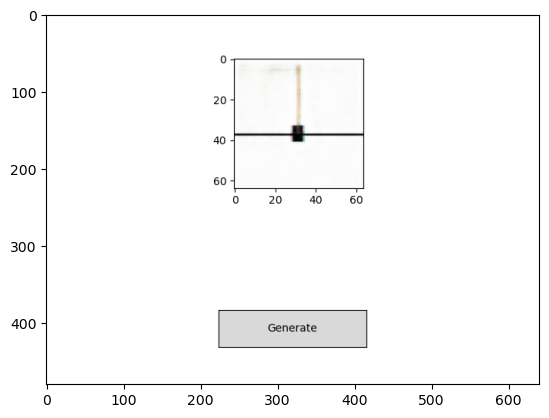

In [28]:
plt.figure()
img = plt.imread('vae_sample 1.png')
plt.imshow(img)
plt.show()

## 2. By default, the model behaves as an autoencoder. Upgrade it to  VAE by modifying `forward()`, `encode()`, and `reparameterize()` in `MyVAE.py`.   
Train and save two generated images.      
#### Q. Describe the difference between the AE and VAE models.
The difference between AAE and VAE models is that we try to use a probability distribution in the VAE. In AE, the latent space vector ditribution is not guaranteed to be a standard normal distribution. This can lead to problem when using AE for generating samples as the distribution is not guaranteed to be centred or continuous in nature. The problems are further exacerbated when the latent space dimensions are large.
A VAE is therefore more suitable as it ensures that the latent space vector distribution is a well-behaved standard normal distribution that can produce more reasonable samples than an AE.

#### Q. What is the reparametrization trick?
The reparameterization trick uses the fact that we are able to learn the standard normal distribution for the latent space. We therefore have access to the mean vector and covariance matrix for the distribution. Since it is guaranteed that the axes in the latent space are independent, the covariance matrix is essentially a diagonal matrix, which can be presented as a vector. We can therefore calculate the standard deviation for each axis in the latent space. The reparameterization trick can help us sample from N(mu, var) using N(0, 1) by randomly sampling a vector eplison from N(0, 1), which is multiplied by standdard deviation and the result is added to the mean mu.

### 2.1 MyVAE.py

In [ ]:
import copy

import torch
from torch import nn
from torch.nn import functional as F


class MyVAE(nn.Module):
    def __init__(self,
                 in_channels: int,
                 latent_dim: int,
                 hidden_dims=None):
        super().__init__()

        self.latent_dim = latent_dim

        # Encoder

        modules = []
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256, 512]

        self.hidden_dims = copy.copy(hidden_dims)

        ##############################
        # replace ??? with proper local variables

        in_dim = in_channels
        for h_dim in self.hidden_dims:
            # one convolution layer
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels=in_dim,
                              out_channels=h_dim,
                              kernel_size=3,
                              stride=2,
                              padding=1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_dim = h_dim

        self.encoder = nn.Sequential(*modules)

        ##############################

        ##############################
        # the central hidden layer of the model.

        # autoencoder version of the representation layer. This is used by default
        self.z_simple = nn.Linear(self.hidden_dims[-1] * 4, latent_dim)

        # VAE Reparametrization Layer
        self.z_mu = nn.Linear(hidden_dims[-1] * 4, latent_dim)
        self.z_var = nn.Linear(hidden_dims[-1] * 4, latent_dim)

        ##############################

        # Decoder
        modules = []

        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] * 4)

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride=2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )

        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
            nn.ConvTranspose2d(hidden_dims[-1],
                               hidden_dims[-1],
                               kernel_size=3,
                               stride=2,
                               padding=1,
                               output_padding=1),
            nn.BatchNorm2d(hidden_dims[-1]),
            nn.LeakyReLU(),
            nn.Conv2d(hidden_dims[-1],
                      out_channels=3,
                      kernel_size=3,
                      padding=1),
            nn.Tanh())

    def encode(self, x):
        """Encodes the input into parameters of a normal distribution."""
        z = self.encoder(x)
        z = torch.flatten(z, start_dim=1)

        ##############################
        # update this along with reparameterize() and forward() to turn this into vae
        # Compute mean and variance of the latent distribution
        # Use mu and var layers we defined in the init

        mu = self.z_mu(z)
        log_var = self.z_var(z)
        z = [mu, log_var]
        # z = self.z_simple(z)

        ##############################

        return z

    def decode(self, z):
        """Latent space to image space"""
        y = self.decoder_input(z)
        y = y.view(-1, self.hidden_dims[-1], 2, 2)  #
        y = self.decoder(y)
        y = self.final_layer(y)
        return y

    def reparameterize(self, mu, logvar):
        """Reparameterization trick: sample from N(mu, var) using N(0,1)"""

        std = torch.exp(0.5 * logvar)

        ##############################
        # update this along with forward() and encode() to turn this into vae

        # hint: torch.randn_like samples from normal distribution,
        # and returns a tensor of the same size as its input
        eps = torch.randn_like(mu)

        ##############################

        return eps * std + mu

    def forward(self, x):

        ##############################
        # update this along with reparametrize() and encode() to turn this into vae

        # z = self.encode(x)
        # mu = torch.zeros_like(z)
        # log_var = torch.zeros_like(z)

        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)

        ##############################

        return [self.decode(z), x, mu, log_var]

    def loss(self, x, y, z_mu, z_log_var, kl_w):
        """VAE loss
        :param kl_w: Account for the minibatch samples from the dataset"""

        recons_loss = F.mse_loss(y, x)

        kl_loss = torch.mean(-0.5 * torch.sum(1 + z_log_var - z_mu ** 2 - z_log_var.exp(), dim=1), dim=0)

        loss = recons_loss + kl_w * kl_loss
        return loss

    def sample(self, z=None, device='cpu'):
        """Sample image from the latent space."""
        if not z:
            z = torch.randn(1, self.latent_dim).to(device)
        else:
            assert z.shape[1] == self.latent_dim, "z must be of shape [1, {}]".format(self.latent_dim)

        y = torch.clamp(self.decode(z), 0.0, 1.0)
        return y

    def generate(self, x):
        """return the reconstructed image from x"""
        return self.forward(x)[0]


if __name__ == "__main__":
    vae = MyVAE(3, 10)
    x = torch.randn(5, 3, 64, 64)
    y, _, mu, logvar = vae(x)
    loss = vae.loss(y, x, mu, logvar, 1)
    print(loss)

### 2.2 train_vae.py - (unchanged from 1.2)

In [ ]:
import random
import torch
import gym
import numpy as np
import cv2
import matplotlib.pyplot as plt

from torch import optim


# we will crop the image to remove the top and bottom (those are always white)
crop_proportions = (0.4, 0.0, 1.0, 1.0)

# after the crop, we will reduce the image size to these dimensions for faster training
img_dim = (64, 64)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def train_vae():

    # initialize the gym environment
    #########################

    # try different environments
    env = gym.make("CartPole-v1")

    #########################
    # first observation from the environment
    obs = env.reset()
    img = env.render(mode='rgb_array')
    crop_dim = (
        int(crop_proportions[0] * img.shape[0]),
        int(crop_proportions[1] * img.shape[1]),
        int(crop_proportions[2] * img.shape[0]),
        int(crop_proportions[3] * img.shape[1])
    )

    # VAE

    input_channels = 3
    latent_dim = 10
    training_size = 2000
    batch_size = latent_dim * 10
    n_epochs = 400

    # initialize the VAE
    # VAE model
    vae = MyVAE(
        in_channels=input_channels,
        latent_dim=latent_dim,
    ).to(device)
    optimizer = optim.Adam(vae.parameters(), lr=0.001)

    imgs = np.zeros((training_size, input_channels, *img_dim), dtype=np.float32)

    # Collect pixel data from the gym

    # episode frame counter
    frame_idx = 0

    for i in range(training_size):
        frame_idx += 1

        # get a random action in this environment
        action = env.action_space.sample()

        # obs is observation data from the env. 
        # Look at the gym code to find which one is a pole angle. 
        # https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py
        obs, reward, done, info = env.step(action)

        # get pixel observations, crop, and resize
        img = env.render(mode='rgb_array')
        img = img[crop_dim[0]: crop_dim[2], crop_dim[1]: crop_dim[3], :]
        img = cv2.resize(img, dsize=img_dim, interpolation=cv2.INTER_CUBIC)
        # how the model will see the image after crop and resize
        # cv2.imshow('img', img)
        # cv2.waitKey(1)
        img = img.swapaxes(0, 2).reshape((1, input_channels, *img_dim)).astype(np.float32) / 255.0

        #################

        # add some conditional logic to save the images you need
        # collect data
        # if obs???:
        imgs[i] = img

        #################

        #################

        # update the reset conditions to save the images you need
        # if ???:
        if done:
            obs = env.reset()
            frame_idx = 0

        #################

    env.close()

    # visualization init
    plt.ion()
    plt.show()

    # train VAE
    for i in range(n_epochs):
        # observations for cvae to use as labels
        start_idx = random.randint(0, training_size - batch_size)

        train_imgs = imgs[start_idx : start_idx + batch_size]

        out_imgs = vae(
            torch.from_numpy(train_imgs.copy()).to(device),
        )
        loss = vae.loss(*out_imgs, kl_w=0.0005)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(loss)

        # get a few generated images
        rand_idx = np.random.randint(0, batch_size - 1)
        im = out_imgs[0][rand_idx: rand_idx + 1].detach().cpu().numpy().reshape(
            (1, 3, *img_dim)).swapaxes(1, 3)
        im = (im * 255.0).astype(np.uint8)

        # show generated image
        plt.subplot(
            np.ceil(np.sqrt(1 * n_epochs)).astype(int),
            np.ceil(np.sqrt(1 * n_epochs)).astype(int),
            i + 1
        )
        plt.imshow(im[0], aspect='auto')
        plt.axis('off')
        plt.show()
        plt.pause(0.1)

    # save our model
    torch.save(vae.state_dict(), 'vae.pth')
    plt.savefig('vae_training.png')
    plt.show()


if __name__ == '__main__':
    train_vae()

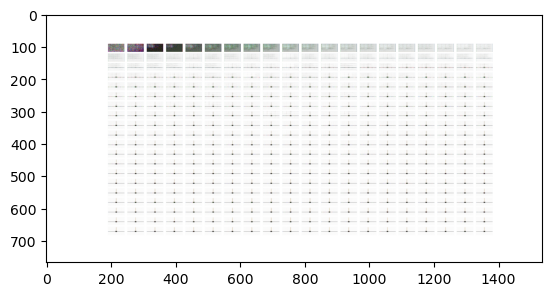

In [29]:
plt.figure()
img = plt.imread('vae_training 2.png')
plt.imshow(img)
plt.show()

### 2.3 sample.py (unchanged from 1.3)

In [ ]:
from argparse import ArgumentParser

import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Button


img_dim = (64, 64)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def my_vae_generate(filepath):
    vae = MyVAE(in_channels=3, latent_dim=10).to(device)
    vae.load_state_dict(torch.load(filepath))

    def generate(_):
        out_img = vae.sample(device=device)
        im = out_img[0].detach().cpu().numpy()
        im = im.reshape((3, *img_dim)).swapaxes(0, 2)
        im = (im * 255.0).astype(np.uint8)
        plt.subplot(2, 1, 1)
        plt.imshow(im)
        plt.show()

    plt.subplot(2, 1, 2)
    plt.axis('off')
    b = Button(plt.axes([0.35, 0.1, 0.30, 0.10]), 'Generate')
    b.on_clicked(generate)
    generate(None)
    plt.show()


if __name__ == "__main__":
    parser = ArgumentParser()
    parser.add_argument("-f", "--file", type=str, default="vae.pth", help="file name")
    args = parser.parse_args()

    my_vae_generate(args.file)


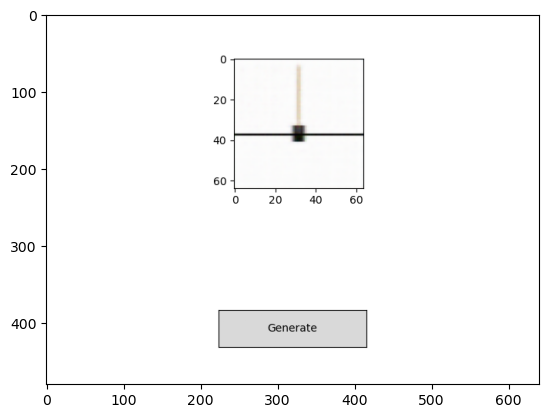

In [30]:
plt.figure()
img = plt.imread('vae_sample 2.png')
plt.imshow(img)
plt.show()

## 3. Update the `train_vae.py` to reset the environment after the first 20 observations from each episode.
Train and save two generated images.   
#### Q. When does the cartpole environment return done=True?
The episode ends if any one of the following occurs:
* Termination: Pole Angle is greater than ±12°
* Termination: Cart Position is greater than ±2.4 (center of the cart reaches the edge of the display)
* Truncation: Episode length is greater than 500 (200 for v0)

### 3.1 MyVAE.py (unchanged from 2.1)

In [ ]:
import copy

import torch
from torch import nn
from torch.nn import functional as F


class MyVAE(nn.Module):
    def __init__(self,
                 in_channels: int,
                 latent_dim: int,
                 hidden_dims=None):
        super().__init__()

        self.latent_dim = latent_dim

        # Encoder

        modules = []
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256, 512]

        self.hidden_dims = copy.copy(hidden_dims)

        ##############################
        # replace ??? with proper local variables

        in_dim = in_channels
        for h_dim in self.hidden_dims:
            # one convolution layer
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels=in_dim,
                              out_channels=h_dim,
                              kernel_size=3,
                              stride=2,
                              padding=1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_dim = h_dim

        self.encoder = nn.Sequential(*modules)

        ##############################

        ##############################
        # the central hidden layer of the model.

        # autoencoder version of the representation layer. This is used by default
        self.z_simple = nn.Linear(self.hidden_dims[-1] * 4, latent_dim)

        # VAE Reparametrization Layer
        self.z_mu = nn.Linear(hidden_dims[-1] * 4, latent_dim)
        self.z_var = nn.Linear(hidden_dims[-1] * 4, latent_dim)

        ##############################

        # Decoder
        modules = []

        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] * 4)

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride=2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )

        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
            nn.ConvTranspose2d(hidden_dims[-1],
                               hidden_dims[-1],
                               kernel_size=3,
                               stride=2,
                               padding=1,
                               output_padding=1),
            nn.BatchNorm2d(hidden_dims[-1]),
            nn.LeakyReLU(),
            nn.Conv2d(hidden_dims[-1],
                      out_channels=3,
                      kernel_size=3,
                      padding=1),
            nn.Tanh())

    def encode(self, x):
        """Encodes the input into parameters of a normal distribution."""
        z = self.encoder(x)
        z = torch.flatten(z, start_dim=1)

        ##############################
        # update this along with reparameterize() and forward() to turn this into vae
        # Compute mean and variance of the latent distribution
        # Use mu and var layers we defined in the init

        mu = self.z_mu(z)
        log_var = self.z_var(z)
        z = [mu, log_var]
        # z = self.z_simple(z)

        ##############################

        return z

    def decode(self, z):
        """Latent space to image space"""
        y = self.decoder_input(z)
        y = y.view(-1, self.hidden_dims[-1], 2, 2)  #
        y = self.decoder(y)
        y = self.final_layer(y)
        return y

    def reparameterize(self, mu, logvar):
        """Reparameterization trick: sample from N(mu, var) using N(0,1)"""

        std = torch.exp(0.5 * logvar)

        ##############################
        # update this along with forward() and encode() to turn this into vae

        # hint: torch.randn_like samples from normal distribution,
        # and returns a tensor of the same size as its input
        eps = torch.randn_like(mu)

        ##############################

        return eps * std + mu

    def forward(self, x):

        ##############################
        # update this along with reparametrize() and encode() to turn this into vae

        # z = self.encode(x)
        # mu = torch.zeros_like(z)
        # log_var = torch.zeros_like(z)

        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)

        ##############################

        return [self.decode(z), x, mu, log_var]

    def loss(self, x, y, z_mu, z_log_var, kl_w):
        """VAE loss
        :param kl_w: Account for the minibatch samples from the dataset"""

        recons_loss = F.mse_loss(y, x)

        kl_loss = torch.mean(-0.5 * torch.sum(1 + z_log_var - z_mu ** 2 - z_log_var.exp(), dim=1), dim=0)

        loss = recons_loss + kl_w * kl_loss
        return loss

    def sample(self, z=None, device='cpu'):
        """Sample image from the latent space."""
        if not z:
            z = torch.randn(1, self.latent_dim).to(device)
        else:
            assert z.shape[1] == self.latent_dim, "z must be of shape [1, {}]".format(self.latent_dim)

        y = torch.clamp(self.decode(z), 0.0, 1.0)
        return y

    def generate(self, x):
        """return the reconstructed image from x"""
        return self.forward(x)[0]


if __name__ == "__main__":
    vae = MyVAE(3, 10)
    x = torch.randn(5, 3, 64, 64)
    y, _, mu, logvar = vae(x)
    loss = vae.loss(y, x, mu, logvar, 1)
    print(loss)

### 3.2 train_vae.py

In [ ]:
import random
import torch
import gym
import numpy as np
import cv2
import matplotlib.pyplot as plt

from torch import optim

from MyVAE import MyVAE


# we will crop the image to remove the top and bottom (those are always white)
crop_proportions = (0.4, 0.0, 1.0, 1.0)

# after the crop, we will reduce the image size to these dimensions for faster training
img_dim = (64, 64)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def train_vae():

    # initialize the gym environment
    #########################

    # try different environments
    env = gym.make("CartPole-v1")

    #########################
    # first observation from the environment
    obs = env.reset()
    img = env.render(mode='rgb_array')
    crop_dim = (
        int(crop_proportions[0] * img.shape[0]),
        int(crop_proportions[1] * img.shape[1]),
        int(crop_proportions[2] * img.shape[0]),
        int(crop_proportions[3] * img.shape[1])
    )

    # VAE

    input_channels = 3
    latent_dim = 10
    training_size = 2000
    batch_size = latent_dim * 10
    n_epochs = 400

    # initialize the VAE
    # VAE model
    vae = MyVAE(
        in_channels=input_channels,
        latent_dim=latent_dim,
    ).to(device)
    optimizer = optim.Adam(vae.parameters(), lr=0.001)

    imgs = np.zeros((training_size, input_channels, *img_dim), dtype=np.float32)

    # Collect pixel data from the gym

    # episode frame counter
    frame_idx = 0

    for i in range(training_size):
        frame_idx += 1

        # get a random action in this environment
        action = env.action_space.sample()

        # obs is observation data from the env. 
        # Look at the gym code to find which one is a pole angle. 
        # https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py
        obs, reward, done, info = env.step(action)

        # get pixel observations, crop, and resize
        img = env.render(mode='rgb_array')
        img = img[crop_dim[0]: crop_dim[2], crop_dim[1]: crop_dim[3], :]
        img = cv2.resize(img, dsize=img_dim, interpolation=cv2.INTER_CUBIC)
        # how the model will see the image after crop and resize
        # cv2.imshow('img', img)
        # cv2.waitKey(1)
        img = img.swapaxes(0, 2).reshape((1, input_channels, *img_dim)).astype(np.float32) / 255.0

        #################

        # add some conditional logic to save the images you need
        # collect data
        # if obs???:
        imgs[i] = img

        #################

        #################

        # update the reset conditions to save the images you need
        # if ???:
        if done or frame_idx == 20:
            obs = env.reset()
            frame_idx = 0

        #################

    env.close()

    # visualization init
    plt.ion()
    plt.show()

    # train VAE
    for i in range(n_epochs):
        # observations for cvae to use as labels
        start_idx = random.randint(0, training_size - batch_size)

        train_imgs = imgs[start_idx : start_idx + batch_size]

        out_imgs = vae(
            torch.from_numpy(train_imgs.copy()).to(device),
        )
        loss = vae.loss(*out_imgs, kl_w=0.0005)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(loss)

        # get a few generated images
        rand_idx = np.random.randint(0, batch_size - 1)
        im = out_imgs[0][rand_idx: rand_idx + 1].detach().cpu().numpy().reshape(
            (1, 3, *img_dim)).swapaxes(1, 3)
        im = (im * 255.0).astype(np.uint8)

        # show generated image
        plt.subplot(
            np.ceil(np.sqrt(1 * n_epochs)).astype(int),
            np.ceil(np.sqrt(1 * n_epochs)).astype(int),
            i + 1
        )
        plt.imshow(im[0], aspect='auto')
        plt.axis('off')
        plt.show()
        plt.pause(0.1)

    # save our model
    torch.save(vae.state_dict(), 'vae.pth')
    plt.savefig('vae_training.png')
    plt.show()


if __name__ == '__main__':
    train_vae()

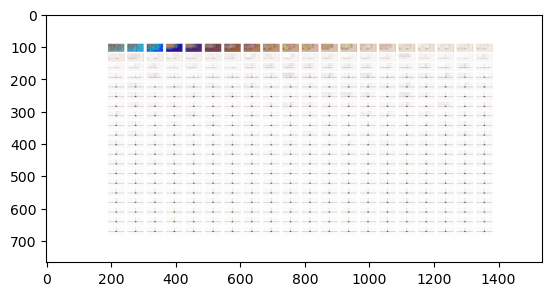

In [31]:
plt.figure()
img = plt.imread('vae_training 3.png')
plt.imshow(img)
plt.show()

### 3.3 sample_vae.py (unchanged from 1.3)

In [ ]:
from argparse import ArgumentParser

import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Button

from MyVAE import MyVAE


img_dim = (64, 64)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def my_vae_generate(filepath):
    vae = MyVAE(in_channels=3, latent_dim=10).to(device)
    vae.load_state_dict(torch.load(filepath))

    def generate(_):
        out_img = vae.sample(device=device)
        im = out_img[0].detach().cpu().numpy()
        im = im.reshape((3, *img_dim)).swapaxes(0, 2)
        im = (im * 255.0).astype(np.uint8)
        plt.subplot(2, 1, 1)
        plt.imshow(im)
        plt.show()

    plt.subplot(2, 1, 2)
    plt.axis('off')
    b = Button(plt.axes([0.35, 0.1, 0.30, 0.10]), 'Generate')
    b.on_clicked(generate)
    generate(None)
    plt.show()


if __name__ == "__main__":
    parser = ArgumentParser()
    parser.add_argument("-f", "--file", type=str, default="vae.pth", help="file name")
    args = parser.parse_args()

    my_vae_generate(args.file)


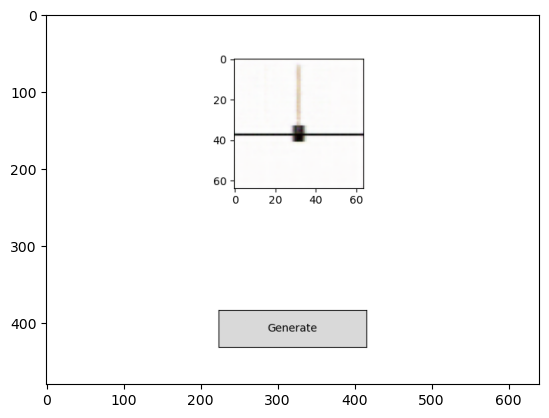

In [32]:
plt.figure()
img = plt.imread('vae_sample 3.png')
plt.imshow(img)
plt.show()

## 4. Update the `train_vae.py` train vae on  observations with a custom angle range.
Pick some max and min vales for image observations that will make generated observations look different from the previous outputs. Don't use states that too far from the initialization state, so that the sampling doesn't take too long.    
Train and save two generated images.

### 4.1 MyVAE (unchanged from 2.1)

In [ ]:
import copy

import torch
from torch import nn
from torch.nn import functional as F


class MyVAE(nn.Module):
    def __init__(self,
                 in_channels: int,
                 latent_dim: int,
                 hidden_dims=None):
        super().__init__()

        self.latent_dim = latent_dim

        # Encoder

        modules = []
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256, 512]

        self.hidden_dims = copy.copy(hidden_dims)

        ##############################
        # replace ??? with proper local variables

        in_dim = in_channels
        for h_dim in self.hidden_dims:
            # one convolution layer
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels=in_dim,
                              out_channels=h_dim,
                              kernel_size=3,
                              stride=2,
                              padding=1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_dim = h_dim

        self.encoder = nn.Sequential(*modules)

        ##############################

        ##############################
        # the central hidden layer of the model.

        # autoencoder version of the representation layer. This is used by default
        self.z_simple = nn.Linear(self.hidden_dims[-1] * 4, latent_dim)

        # VAE Reparametrization Layer
        self.z_mu = nn.Linear(hidden_dims[-1] * 4, latent_dim)
        self.z_var = nn.Linear(hidden_dims[-1] * 4, latent_dim)

        ##############################

        # Decoder
        modules = []

        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] * 4)

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride=2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )

        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
            nn.ConvTranspose2d(hidden_dims[-1],
                               hidden_dims[-1],
                               kernel_size=3,
                               stride=2,
                               padding=1,
                               output_padding=1),
            nn.BatchNorm2d(hidden_dims[-1]),
            nn.LeakyReLU(),
            nn.Conv2d(hidden_dims[-1],
                      out_channels=3,
                      kernel_size=3,
                      padding=1),
            nn.Tanh())

    def encode(self, x):
        """Encodes the input into parameters of a normal distribution."""
        z = self.encoder(x)
        z = torch.flatten(z, start_dim=1)

        ##############################
        # update this along with reparameterize() and forward() to turn this into vae
        # Compute mean and variance of the latent distribution
        # Use mu and var layers we defined in the init

        mu = self.z_mu(z)
        log_var = self.z_var(z)
        z = [mu, log_var]
        # z = self.z_simple(z)

        ##############################

        return z

    def decode(self, z):
        """Latent space to image space"""
        y = self.decoder_input(z)
        y = y.view(-1, self.hidden_dims[-1], 2, 2)  #
        y = self.decoder(y)
        y = self.final_layer(y)
        return y

    def reparameterize(self, mu, logvar):
        """Reparameterization trick: sample from N(mu, var) using N(0,1)"""

        std = torch.exp(0.5 * logvar)

        ##############################
        # update this along with forward() and encode() to turn this into vae

        # hint: torch.randn_like samples from normal distribution,
        # and returns a tensor of the same size as its input
        eps = torch.randn_like(mu)

        ##############################

        return eps * std + mu

    def forward(self, x):

        ##############################
        # update this along with reparametrize() and encode() to turn this into vae

        # z = self.encode(x)
        # mu = torch.zeros_like(z)
        # log_var = torch.zeros_like(z)

        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)

        ##############################

        return [self.decode(z), x, mu, log_var]

    def loss(self, x, y, z_mu, z_log_var, kl_w):
        """VAE loss
        :param kl_w: Account for the minibatch samples from the dataset"""

        recons_loss = F.mse_loss(y, x)

        kl_loss = torch.mean(-0.5 * torch.sum(1 + z_log_var - z_mu ** 2 - z_log_var.exp(), dim=1), dim=0)

        loss = recons_loss + kl_w * kl_loss
        return loss

    def sample(self, z=None, device='cpu'):
        """Sample image from the latent space."""
        if not z:
            z = torch.randn(1, self.latent_dim).to(device)
        else:
            assert z.shape[1] == self.latent_dim, "z must be of shape [1, {}]".format(self.latent_dim)

        y = torch.clamp(self.decode(z), 0.0, 1.0)
        return y

    def generate(self, x):
        """return the reconstructed image from x"""
        return self.forward(x)[0]


if __name__ == "__main__":
    vae = MyVAE(3, 10)
    x = torch.randn(5, 3, 64, 64)
    y, _, mu, logvar = vae(x)
    loss = vae.loss(y, x, mu, logvar, 1)
    print(loss)

### 4.2 train_vae.py

In [ ]:
import random
import torch
import gym
import numpy as np
import cv2
import matplotlib.pyplot as plt

from torch import optim

from MyVAE import MyVAE


# we will crop the image to remove the top and bottom (those are always white)
crop_proportions = (0.4, 0.0, 1.0, 1.0)

# after the crop, we will reduce the image size to these dimensions for faster training
img_dim = (64, 64)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def train_vae():

    # initialize the gym environment
    #########################

    # try different environments
    env = gym.make("CartPole-v1")

    #########################
    # first observation from the environment
    obs = env.reset()
    img = env.render(mode='rgb_array')
    crop_dim = (
        int(crop_proportions[0] * img.shape[0]),
        int(crop_proportions[1] * img.shape[1]),
        int(crop_proportions[2] * img.shape[0]),
        int(crop_proportions[3] * img.shape[1])
    )

    # VAE

    input_channels = 3
    latent_dim = 10
    training_size = 2000
    batch_size = latent_dim * 10
    n_epochs = 400

    # initialize the VAE
    # VAE model
    vae = MyVAE(
        in_channels=input_channels,
        latent_dim=latent_dim,
    ).to(device)
    optimizer = optim.Adam(vae.parameters(), lr=0.001)

    imgs = np.zeros((training_size, input_channels, *img_dim), dtype=np.float32)
    filter_flag = [False]*training_size

    # Collect pixel data from the gym

    # episode frame counter
    frame_idx = 0

    for i in range(training_size):
        frame_idx += 1

        # get a random action in this environment
        action = env.action_space.sample()

        # obs is observation data from the env. 
        # Look at the gym code to find which one is a pole angle. 
        # https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py
        obs, reward, done, info = env.step(action)

        # get pixel observations, crop, and resize
        img = env.render(mode='rgb_array')
        img = img[crop_dim[0]: crop_dim[2], crop_dim[1]: crop_dim[3], :]
        img = cv2.resize(img, dsize=img_dim, interpolation=cv2.INTER_CUBIC)
        # how the model will see the image after crop and resize
        # cv2.imshow('img', img)
        # cv2.waitKey(1)
        img = img.swapaxes(0, 2).reshape((1, input_channels, *img_dim)).astype(np.float32) / 255.0

        #################

        # add some conditional logic to save the images you need
        # collect data
        # if obs???:
        if obs[2] < -0.2:
            print("pole angle: ", obs[2]*180/np.pi)
            imgs[i] = img
            filter_flag[i] = True
        # imgs[i] = img

        #################

        #################

        # update the reset conditions to save the images you need
        # if ???:
        if done or frame_idx == 20:
            obs = env.reset()
            frame_idx = 0

        #################

    env.close()

    # visualization init
    plt.ion()
    plt.show()

    # filter images
    imgs = imgs[np.where(filter_flag)]

    # train VAE
    for i in range(n_epochs):
        # observations for cvae to use as labels
        # start_idx = random.randint(0, training_size - batch_size)

        # train_imgs = imgs[start_idx : start_idx + batch_size]
        train_imgs = imgs

        out_imgs = vae(
            torch.from_numpy(train_imgs.copy()).to(device),
        )
        loss = vae.loss(*out_imgs, kl_w=0.0005)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(loss)

        # get a few generated images
        rand_idx = np.random.randint(0, len(train_imgs) - 1)
        im = out_imgs[0][rand_idx: rand_idx + 1].detach().cpu().numpy().reshape(
            (1, 3, *img_dim)).swapaxes(1, 3)
        im = (im * 255.0).astype(np.uint8)

        # show generated image
        plt.subplot(
            np.ceil(np.sqrt(1 * n_epochs)).astype(int),
            np.ceil(np.sqrt(1 * n_epochs)).astype(int),
            i + 1
        )
        plt.imshow(im[0], aspect='auto')
        plt.axis('off')
        plt.show()
        plt.pause(0.1)

    # save our model
    torch.save(vae.state_dict(), 'vae.pth')
    plt.savefig('vae_training.png')
    plt.show()


if __name__ == '__main__':
    train_vae()

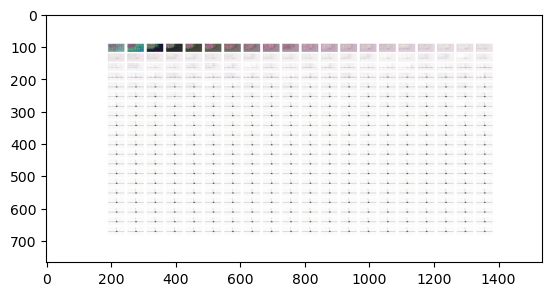

In [33]:
plt.figure()
img = plt.imread('vae_training 4.png')
plt.imshow(img)
plt.show()

### sample_vae.py (unchanged from 1.3)

In [ ]:
from argparse import ArgumentParser

import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Button

from MyVAE import MyVAE


img_dim = (64, 64)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def my_vae_generate(filepath):
    vae = MyVAE(in_channels=3, latent_dim=10).to(device)
    vae.load_state_dict(torch.load(filepath))

    def generate(_):
        out_img = vae.sample(device=device)
        im = out_img[0].detach().cpu().numpy()
        im = im.reshape((3, *img_dim)).swapaxes(0, 2)
        im = (im * 255.0).astype(np.uint8)
        plt.subplot(2, 1, 1)
        plt.imshow(im)
        plt.show()

    plt.subplot(2, 1, 2)
    plt.axis('off')
    b = Button(plt.axes([0.35, 0.1, 0.30, 0.10]), 'Generate')
    b.on_clicked(generate)
    generate(None)
    plt.show()


if __name__ == "__main__":
    parser = ArgumentParser()
    parser.add_argument("-f", "--file", type=str, default="vae.pth", help="file name")
    args = parser.parse_args()

    my_vae_generate(args.file)


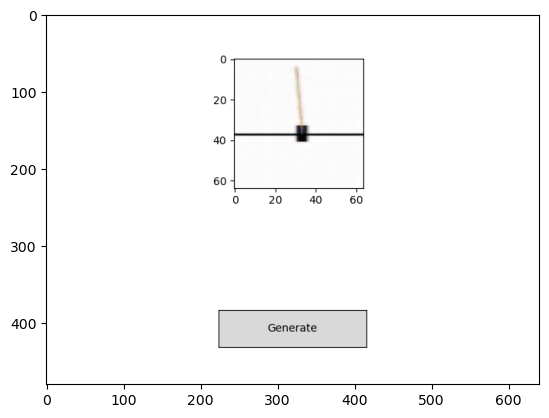

In [34]:
plt.figure()
img = plt.imread('vae_sample 4.png')
plt.imshow(img)
plt.show()

## 5. Pick another gym environment and train VAE on it.    

For this exercise I will be using the Pendulum gym environment. `MyVAE.py` and `sample_vae.py` remain unchanged.

### 5.1 train_vae_pendulum.py

In [ ]:
import random
import torch
import gym
import numpy as np
import cv2
import matplotlib.pyplot as plt

from torch import optim

from MyVAE import MyVAE


# we will crop the image to remove the top and bottom (those are always white)
crop_proportions = (0.4, 0.0, 1.0, 1.0)

# after the crop, we will reduce the image size to these dimensions for faster training
img_dim = (64, 64)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def train_vae():

    # initialize the gym environment
    #########################

    # try different environments
    env = gym.make("Pendulum-v1")

    #########################
    # first observation from the environment
    obs = env.reset()
    img = env.render(mode='rgb_array')
    crop_dim = (
        int(crop_proportions[0] * img.shape[0]),
        int(crop_proportions[1] * img.shape[1]),
        int(crop_proportions[2] * img.shape[0]),
        int(crop_proportions[3] * img.shape[1])
    )

    # VAE

    input_channels = 3
    latent_dim = 10
    training_size = 2000
    batch_size = latent_dim * 10
    n_epochs = 400

    # initialize the VAE
    # VAE model
    vae = MyVAE(
        in_channels=input_channels,
        latent_dim=latent_dim,
    ).to(device)
    optimizer = optim.Adam(vae.parameters(), lr=0.001)

    imgs = np.zeros((training_size, input_channels, *img_dim), dtype=np.float32)
    filter_flag = [False]*training_size

    # Collect pixel data from the gym

    # episode frame counter
    frame_idx = 0

    for i in range(training_size):
        frame_idx += 1

        # get a random action in this environment
        action = env.action_space.sample()

        # obs is observation data from the env. 
        # Look at the gym code to find which one is a pole angle. 
        # https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py
        obs, reward, done, info = env.step(action)

        # get pixel observations, crop, and resize
        img = env.render(mode='rgb_array')
        img = img[crop_dim[0]: crop_dim[2], crop_dim[1]: crop_dim[3], :]
        img = cv2.resize(img, dsize=img_dim, interpolation=cv2.INTER_CUBIC)
        # how the model will see the image after crop and resize
        # cv2.imshow('img', img)
        # cv2.waitKey(1)
        img = img.swapaxes(0, 2).reshape((1, input_channels, *img_dim)).astype(np.float32) / 255.0

        #################

        # add some conditional logic to save the images you need
        # collect data
        # if obs???:
        if obs[0] < 0 and -0.5 < obs[1] < 0:
            # import pdb; pdb.set_trace()

            imgs[i] = img
            filter_flag[i] = True
        # imgs[i] = img

        #################

        #################

        # update the reset conditions to save the images you need
        # if ???:
        if done or frame_idx == 20:
            obs = env.reset()
            frame_idx = 0

        #################

    env.close()

    # visualization init
    plt.ion()
    plt.show()

    # filter images
    imgs = imgs[np.where(filter_flag)]
    import pdb; pdb.set_trace()

    # train VAE
    for i in range(n_epochs):
        # observations for cvae to use as labels
        # start_idx = random.randint(0, training_size - batch_size)

        # train_imgs = imgs[start_idx : start_idx + batch_size]
        train_imgs = imgs

        out_imgs = vae(
            torch.from_numpy(train_imgs.copy()).to(device),
        )
        loss = vae.loss(*out_imgs, kl_w=0.0005)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(loss)

        # get a few generated images
        rand_idx = np.random.randint(0, len(train_imgs) - 1)
        im = out_imgs[0][rand_idx: rand_idx + 1].detach().cpu().numpy().reshape(
            (1, 3, *img_dim)).swapaxes(1, 3)
        im = (im * 255.0).astype(np.uint8)

        # show generated image
        plt.subplot(
            np.ceil(np.sqrt(1 * n_epochs)).astype(int),
            np.ceil(np.sqrt(1 * n_epochs)).astype(int),
            i + 1
        )
        plt.imshow(im[0], aspect='auto')
        plt.axis('off')
        plt.show()
        plt.pause(0.1)

    # save our model
    torch.save(vae.state_dict(), 'vae_pendulum.pth')
    plt.savefig('vae_training_pendulum.png')
    plt.show()


if __name__ == '__main__':
    train_vae()

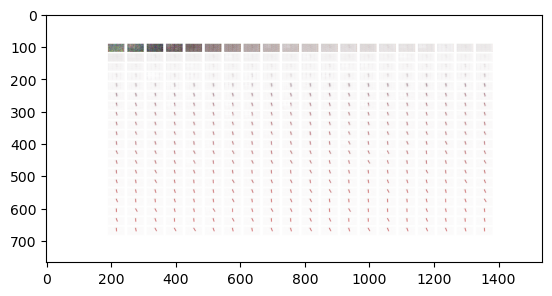

In [35]:
plt.figure()
img = plt.imread('vae_training_pendulum.png')
plt.imshow(img)
plt.show()

### 5.2 sample_vae.py

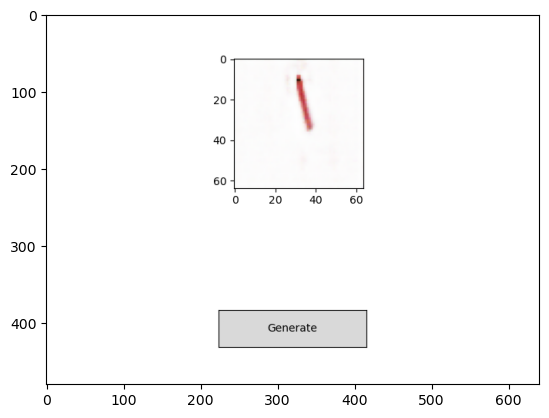

In [36]:
plt.figure()
img = plt.imread('vae_sample_pendulum.png')
plt.imshow(img)
plt.show()